In [3]:
%matplotlib inline

In [5]:
from __future__ import print_function, division
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession

import seaborn as sns
import pandas as pd

import time
import os
import csv
from numpy import array

spark = SparkSession.builder.master("local[2]") \
   .appName("test") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

In [6]:
training = spark.read.format("libsvm").load("../data/sample_libsvm_data.txt")

In [7]:
training.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(692,[127,128,129...|
|  1.0|(692,[158,159,160...|
|  1.0|(692,[124,125,126...|
|  1.0|(692,[152,153,154...|
|  1.0|(692,[151,152,153...|
|  0.0|(692,[129,130,131...|
|  1.0|(692,[158,159,160...|
|  1.0|(692,[99,100,101,...|
|  0.0|(692,[154,155,156...|
|  0.0|(692,[127,128,129...|
|  1.0|(692,[154,155,156...|
|  0.0|(692,[153,154,155...|
|  0.0|(692,[151,152,153...|
|  1.0|(692,[129,130,131...|
|  0.0|(692,[154,155,156...|
|  1.0|(692,[150,151,152...|
|  0.0|(692,[124,125,126...|
|  0.0|(692,[152,153,154...|
|  1.0|(692,[97,98,99,12...|
|  1.0|(692,[124,125,126...|
+-----+--------------------+
only showing top 20 rows



In [45]:
#http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#module-pyspark.ml.classification
#https://mingchen0919.github.io/learning-apache-spark/regularization.html

lr = LogisticRegression(maxIter=20)

In [46]:
lrModel = lr.fit(training)

In [47]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

In [48]:
trainingSummary.areaUnderROC

1.0

In [19]:
trainingSummary.roc

DataFrame[FPR: double, TPR: double]

In [20]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
0.6833149135741672
0.6662875751473734
0.6217068546034618
0.6127265245887887
0.6060347986802873
0.6031750687571562
0.5969621534836274
0.5940743031983118
0.5906089243339022
0.5894724576491042
0.5882187775729587
0.5879723849390044
0.5873496689493397
0.5860067165446026
0.5857200006205047
0.5854248515766242
0.5847678218503692
0.583160560090694
0.5845522087534214
0.5799875196944123
0.5791126341535658


In [21]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))


+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.017543859649122806|
|0.0| 0.03508771929824561|
|0.0| 0.05263157894736842|
|0.0| 0.07017543859649122|
|0.0| 0.08771929824561403|
|0.0| 0.12280701754385964|
|0.0| 0.14035087719298245|
|0.0| 0.15789473684210525|
|0.0| 0.17543859649122806|
|0.0| 0.19298245614035087|
|0.0| 0.22807017543859648|
|0.0| 0.24561403508771928|
|0.0|  0.2631578947368421|
|0.0|  0.2807017543859649|
|0.0|  0.2982456140350877|
|0.0|  0.3157894736842105|
|0.0|  0.3333333333333333|
|0.0|  0.3508771929824561|
|0.0|  0.3684210526315789|
+---+--------------------+
only showing top 20 rows

areaUnderROC: 0.9995920032639739


In [25]:
roc_df = trainingSummary.roc.toPandas()

In [26]:
roc_df.head()

,FPR,TPR
0,0.0,0.000000
1,0.0,0.017544
2,0.0,0.035088
3,0.0,0.052632
4,0.0,0.070175


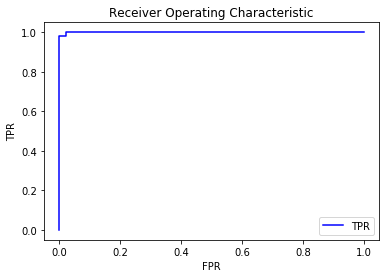

In [27]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(roc_df.FPR, roc_df.TPR, 'b')
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [35]:
#https://baike.baidu.com/item/f-measure
fMeasure = trainingSummary.fMeasureByThreshold

In [36]:
fMeasure.show()

+------------------+--------------------+
|         threshold|           F-Measure|
+------------------+--------------------+
|  0.79777957722041|0.034482758620689655|
|0.7977381731942828| 0.06779661016949151|
|0.7974345311646921|                 0.1|
|0.7973846871133493| 0.13114754098360656|
|0.7973384935348377| 0.16129032258064516|
|0.7972740306097461|             0.21875|
|0.7972206964413223| 0.24615384615384614|
|0.7970695547508623|  0.2727272727272727|
|0.7969653909921725| 0.29850746268656714|
|0.7968786151498606|  0.3235294117647059|
|0.7967272438246795|  0.3714285714285714|
|0.7966956865263234|  0.3943661971830986|
|0.7966574874008476|  0.4166666666666667|
|0.7964931934945851|  0.4383561643835616|
|0.7964287693237343| 0.45945945945945943|
|0.7964049690908118|  0.4799999999999999|
|  0.79636422443222|                 0.5|
|0.7962239941135831|  0.5194805194805194|
|0.7961986011094049|  0.5384615384615384|
|0.7960454874428231|  0.5569620253164557|
+------------------+--------------

In [38]:
# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']


In [39]:
bestThreshold

0.4676574320520744

In [ ]:
fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']).show()

In [40]:
lr.setThreshold(bestThreshold)

LogisticRegression_42d983f22c9e60acc397

In [42]:
model2 = lr.fit(training)

In [43]:
trainingSummary2 = model2.summary

In [44]:
trainingSummary2.areaUnderROC

0.9995920032639739

In [ ]:
spark.stop()